# YouTube Video Sentiment Analysis - Data Collection / Sentiment + Emotion Analysis Script

# By Aryan Shetty

# 🎬 YouTube Movie Trailer Sentiment & Emotion Analysis

## 1. Objective

The goal is to **analyze public sentiment and emotional reactions to movie trailers** using YouTube comments.

---

## 2. Data Sources

- **YouTube API**  
  Used to fetch trailer video metadata and user comments.

- **Hugging Face Pretrained Models**  
  - **Sentiment Analysis**: [`Pretrained Model for Sentiment Analysis`](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)  
  - **Emotion Recognition**: [`Pretrained Model for Emotion Recognition`](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base)

---

## 3. YouTube API Setup

1. Go to [Google Cloud Console](https://console.cloud.google.com/)
2. Create a project and enable the **YouTube Data API v3**
3. Generate an API key
4. Create a `.env` file in your project folder and add:

    ```
    YOUTUBE_API_KEY=your_actual_api_key_here
    ```

5. Load it in your Python code:

    ```python
    from dotenv import load_dotenv
    import os

    load_dotenv()
    YOUTUBE_API_KEY = os.getenv("YOUTUBE_API_KEY")
    ```

---

## 4. Methodology

### 4.1 Data Collection

- Search for YouTube videos using keywords like `"Movie Name + Trailer"`
- Retrieve metadata (title, views, likes, comments)
- Collect top-level comments for each video

### 4.2 Text Preprocessing

- Lowercase conversion  
- URL and punctuation removal  
- Non-alphabetic filtering  
- Extra whitespace removal  
- Truncation to 512 tokens (for model compatibility)

### 4.3 Data Storage

- Processed comment data saved to:
    ```
    movie_data/<movie_name>_comments.csv
    ```
- Sentiment & emotion plots saved to:
    ```
    outputs/<movie_name>_sentiment_distribution.png
    outputs/<movie_name>_emotion_distribution.png
    ```

---

## 5. Visualizations

- **Sentiment Distribution**  
  Bar plot showing number of comments in each sentiment category (Very Negative → Very Positive)

- **Top Emotions**  
  Horizontal bar plot showing emotion percentages per movie

---

## 6. ML Models

### Sentiment Analysis

- **Model**: RoBERTa  
- **Trained on**: Twitter data  
- **Classes**: Positive, Neutral, Negative  
- **Compound Score**: `positive - negative`

### Emotion Recognition

- **Model**: DistilRoBERTa  
- **Trained on**: English emotion-labeled datasets  
- **Classes**: Joy, Sadness, Anger, Fear, Surprise, Disgust, Neutral

---

## 7. Considerations

- API rate limiting handled using `time.sleep(0.5)`
- Only top-level comments are analyzed (not replies)
- Long comments are truncated at 512 tokens
- Sentiment is categorized using compound score bins
- One CSV and two visualizations are generated per movie


In [31]:
import pandas as pd
import datetime
import time
import re
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from googleapiclient.discovery import build
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
# this is used to import private variables from YouTube -> you can either modify the script using your own credentials
# or create a .env with them.
from dotenv import load_dotenv

In [33]:
class YouTubeDataCollector:
    def __init__(self, api_key):
        """
        initialize the YouTube API client
        
        parameters:
        - api_key: your YouTube API key
        """
        self.youtube = build('youtube', 'v3', developerKey=api_key)
        
        # initialize pretrained sentiment analysis model
        # using RoBERTa model fine-tuned for sentiment analysis on tweets
        # source: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
        self.sentiment_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
        self.sentiment_tokenizer = AutoTokenizer.from_pretrained(self.sentiment_model_name)
        self.sentiment_model = AutoModelForSequenceClassification.from_pretrained(self.sentiment_model_name)

        # doing the same but for emotion analysis
        # source: https://huggingface.co/j-hartmann/emotion-english-distilroberta-base
        self.emotion_model_name = "j-hartmann/emotion-english-distilroberta-base"
        self.emotion_tokenizer = AutoTokenizer.from_pretrained(self.emotion_model_name)
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(self.emotion_model_name)

        # get emotion labels dynamically from the model configuration
        self.emotion_labels = [
            self.emotion_model.config.id2label[i] 
            for i in range(len(self.emotion_model.config.id2label))
        ]

        # create emotion column names
        self.emotion_columns = [f"{label.lower()}_emotion" for label in self.emotion_labels]

        # create folder for data if it doesn't exist
        if not os.path.exists('movie_data'):
            os.makedirs('movie_data')
    
    def clean_text(self, text):
        """
        clean and preprocess text data
        
        parameters:
        - text: text to clean
        
        returns:
        - cleaned text
        """
        if text is None:
            return ""
        
        # to lowercase
        text = text.lower()
        
        # remove urls
        text = re.sub(r'http\S+', '', text)
        
        # keep only letters and spaces
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def get_sentiment_scores(self, text):
        """
        calculate sentiment scores for a given text using the pretrained model
        
        parameters:
        - text: text to analyze
        
        returns:
        - dictionary with sentiment scores
        """
        if not text:
            # return neutral sentiment if text is empty
            return {
                'compound': 0,
                'pos': 0,
                'neu': 1,
                'neg': 0
            }
        
        # truncate text if it's too long for the model
        max_length = 512
        if len(text) > max_length:
            text = text[:max_length]
        
        encoded_input = self.sentiment_tokenizer(text, return_tensors='pt', truncation=True, max_length=512)

        # get model output
        with torch.no_grad():
            output = self.sentiment_model(**encoded_input)
        
        # get probabilities
        scores = softmax(output.logits[0].numpy())
        
        # map scores to sentiment categories (negative, neutral, positive)
        sentiment_scores = {
            'neg': float(scores[0]),
            'neu': float(scores[1]),
            'pos': float(scores[2]),
            'compound': float(scores[2] - scores[0])
        }
        
        return sentiment_scores
    
    def get_emotion_scores(self, text):
        """
        calculate emotion scores
        
        parameters:
        - text: text to analyze
        
        returns:
        - dictionary with emotion scores
        """
        if not text:
            # return neutral emotion scores if text is empty
            return {label.lower(): 0 for label in self.emotion_labels}
        
        # truncate text if it's too long for the model
        max_length = 512
        if len(text) > max_length:
            text = text[:max_length]
        
        encoded_input = self.emotion_tokenizer(text, return_tensors='pt', truncation=True, max_length=512)

        # get model output
        with torch.no_grad():
            output = self.emotion_model(**encoded_input)
        
        # get probabilities
        scores = softmax(output.logits[0].numpy())
        
        # map scores to emotion categories dynamically
        emotion_mapping = {
            self.emotion_model.config.id2label[i].lower(): float(scores[i]) 
            for i in range(len(self.emotion_labels))
        }
        
        return emotion_mapping
    
    def search_videos(self, search_term, max_results=10):
        """
        search for videos related to a given term
        
        parameters:
        - search_term: term to search for
        - max_results: maximum number of videos to retrieve
        
        returns:
        - list of video IDs
        """
        search_response = self.youtube.search().list(
            q=search_term,
            part='id',
            maxResults=max_results,
            type='video',
            relevanceLanguage='en',
            order='relevance'
        ).execute()
        
        video_ids = [item['id']['videoId'] for item in search_response.get('items', [])]
        return video_ids
        
    
    def get_video_details(self, video_ids):
        """
        get details for given video IDs
        
        parameters:
        - video_ids: list of video IDs
        
        returns:
        - dict with video details
        """
        video_response = self.youtube.videos().list(
            id=','.join(video_ids),
            part='snippet,statistics'
        ).execute()
        
        videos = {}
        for item in video_response.get('items', []):
            video_id = item['id']
            snippet = item['snippet']
            statistics = item['statistics']
            
            videos[video_id] = {
                'title': snippet.get('title', ''),
                'channel': snippet.get('channelTitle', ''),
                'published_at': snippet.get('publishedAt', ''),
                'view_count': int(statistics.get('viewCount', 0)),
                'like_count': int(statistics.get('likeCount', 0)) if 'likeCount' in statistics else 0,
                'comment_count': int(statistics.get('commentCount', 0)) if 'commentCount' in statistics else 0
            }
        
        return videos
        
    
    def get_video_comments(self, video_id, max_comments=100):
        """
        get comments for a specific video
        
        parameters:
        - video_id: ID of the video
        - max_comments: maximum number of comments to retrieve
        
        returns:
        - list of comments
        """
        comments = []
        next_page_token = None
        
        try:
            while len(comments) < max_comments:
                # request comment threads
                request = self.youtube.commentThreads().list(
                    part='snippet',
                    videoId=video_id,
                    maxResults=min(100, max_comments - len(comments)),
                    pageToken=next_page_token,
                    textFormat='plainText'
                )
                
                response = request.execute()
                
                # process comment threads
                for item in response['items']:
                    comment = item['snippet']['topLevelComment']['snippet']
                    
                    # get comment data
                    comment_data = {
                        'id': item['id'],
                        'text': comment['textDisplay'],
                        'author': comment['authorDisplayName'],
                        'published_at': comment['publishedAt'],
                        'like_count': comment['likeCount'],
                        'video_id': video_id
                    }
                    
                    comments.append(comment_data)
                
                # check for next page
                next_page_token = response.get('nextPageToken')
                if not next_page_token or len(comments) >= max_comments:
                    break
                
                # sleep to avoid rate limits
                time.sleep(0.5)

        except Exception as e:
            print(f"Error collecting comments for video {video_id}: {e}")
        
        return comments
    
    def collect_youtube_data(self, search_term, max_videos=5, max_comments_per_video=200):
        """
        collect YouTube data for a specific search term
        
        parameters:
        - search_term: term to search for
        - max_videos: maximum number of videos to analyze
        - max_comments_per_video: maximum number of comments to retrieve per video
        
        returns:
        - df with collected data
        """
        # search for videos
        video_ids = self.search_videos(search_term, max_results=max_videos)
        
        # get video details
        videos = self.get_video_details(video_ids)
        
        # collect comments for each video
        all_comments = []
        total_comments = 0
        
        for video_id, video_info in videos.items():
            print(f"Collecting comments for video: {video_info['title']}")
            
            # get comments
            video_comments = self.get_video_comments(video_id, max_comments=max_comments_per_video)
            
            # process each comment
            for comment in video_comments:
                # clean comment text
                clean_comment = self.clean_text(comment['text'])
                
                # get sentiment scores
                sentiment_scores = self.get_sentiment_scores(clean_comment)
                
                # get emotion scores
                emotion_scores = self.get_emotion_scores(clean_comment)
                
                # process comment
                comment_data = {
                    'id': comment['id'],
                    'video_id': video_id,
                    'video_title': video_info['title'],
                    'channel': video_info['channel'],
                    'text': comment['text'],
                    'author': comment['author'],
                    'published_at': comment['published_at'],
                    'like_count': comment['like_count'],
                    'compound_sentiment': sentiment_scores['compound'],
                    'positive_sentiment': sentiment_scores['pos'],
                    'neutral_sentiment': sentiment_scores['neu'],
                    'negative_sentiment': sentiment_scores['neg'],
                    **{f"{k}_emotion": v for k, v in emotion_scores.items()}
                }
                
                all_comments.append(comment_data)
            
            total_comments += len(video_comments)
            
            # sleep to avoid rate limits
            time.sleep(0.5)
        
        # create dataframe
        comments_df = pd.DataFrame(all_comments)
        
        # save to CSV
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        search_term_cleaned = search_term.replace(" ", "_").lower()
        
        filename = f"movie_data/{search_term_cleaned}_youtube_comments_{timestamp}.csv"
        
        comments_df.to_csv(filename, index=False)
        
        print(f"Data collection is complete: {len(videos)} videos and {total_comments} comments")
        print(f"Data saved to {filename}")
        
        return comments_df
    
    def analyze_sentiment_and_emotion_distribution(self, data):
        """
        analyze the sentiment distribution of collected data
        
        parameters:
        - data: df with collected data
        
        returns:
        - dict with sentiment distribution analysis
        """
        # calculate averages for sentiment scores
        sentiment_avg = {
            'Average compound score': data['compound_sentiment'].mean(),
            'Average positive score': data['positive_sentiment'].mean(),
            'Average neutral score': data['neutral_sentiment'].mean(),
            'Average negative score': data['negative_sentiment'].mean()
        }
        
        # categorize sentiments
        data['sentiment_category'] = pd.cut(
            data['compound_sentiment'],
            bins=[-2, -0.6, -0.2, 0.2, 0.6, 2],
            labels=['Very negative', 'Negative', 'Neutral', 'Positive', 'Very positive']
        )
        
        # count by category
        sentiment_counts = data['sentiment_category'].value_counts().to_dict()
        
        # calculate percentages
        total = sum(sentiment_counts.values())
        sentiment_percentages = {k: (v / total) * 100 for k, v in sentiment_counts.items()}
        
        # emotion analysis
        emotion_columns = [col for col in data.columns if col.endswith('_emotion')]

        # calculate average emotion scores
        emotion_avg = {f'Average {col.split("_")[0]} emotion': data[col].mean() for col in emotion_columns}
        
        # calculate total emotion scores across all content
        total_emotion_scores = {}
        for col in emotion_columns:
            emotion_name = col.split('_')[0]
            total_emotion_scores[emotion_name] = data[col].sum()
        
        # sort emotions
        sorted_emotions = sorted(total_emotion_scores.items(), key=lambda x: x[1], reverse=True)

        emotions_dict = {
            'emotions': [emotion for emotion, score in sorted_emotions],
            'emotions_scores': {emotion: score for emotion, score in sorted_emotions}
        }

        # calculate percentages for emotions
        total_emotion_score = sum(total_emotion_scores.values())
        emotions_percentages = {
            emotion: (score / total_emotion_score) * 100 
            for emotion, score in emotions_dict['emotions_scores'].items()
        }
        emotions_dict['emotions_percentages'] = emotions_percentages

        # combine results
        analysis_result = {
            'sentiment_avg': sentiment_avg,
            'sentiment_counts': sentiment_counts,
            'sentiment_percentages': sentiment_percentages,
            'emotion_avg': emotion_avg,
            'emotions': emotions_dict
        }
        
        return analysis_result

    def analyze_by_video(self, data):
        """
        analyze sentiment and emotion by video
        
        parameters:
        - data: df with collected data
        
        returns:
        - df with analysis by video
        """
        # get unique videos
        videos = data['video_id'].unique()
        
        video_analysis = []
        
        for video_id in videos:
            # filter data for this video
            video_data = data[data['video_id'] == video_id]
            
            # get video info
            video_title = video_data['video_title'].iloc[0]
            channel = video_data['channel'].iloc[0]
            
            # calculate average sentiment
            avg_sentiment = video_data['compound_sentiment'].mean()
            avg_positive = video_data['positive_sentiment'].mean()
            avg_negative = video_data['negative_sentiment'].mean()
            
            # calculate dominant emotion
            emotion_columns = [col for col in data.columns if col.endswith('_emotion')]
            emotion_averages = {col.split('_')[0]: video_data[col].mean() for col in emotion_columns}
            dominant_emotion = max(emotion_averages.items(), key=lambda x: x[1])[0]
            
            # store analysis
            video_analysis.append({
                'video_id': video_id,
                'video_title': video_title,
                'channel': channel,
                'comment_count': len(video_data),
                'avg_sentiment': avg_sentiment,
                'avg_positive': avg_positive,
                'avg_negative': avg_negative,
                'dominant_emotion': dominant_emotion
            })
        
        return pd.DataFrame(video_analysis)


In [34]:
movies = ["The Flash", "Barbie", "Oppenheimer", "Snow White"]

for movie in movies:
    print(f"\nProcessing: {movie}")
    search_term = movie + " trailer"
    cleaned_name = movie.lower().replace(" ", "_")

    # collect data
    data = collector.collect_youtube_data(
        search_term=search_term,
        max_videos=3,
        max_comments_per_video=100
    )

    # save raw data
    data.to_csv(f"movie_data/{cleaned_name}_comments.csv", index=False)

    # analyze sentiment and emotion
    analysis = collector.analyze_sentiment_and_emotion_distribution(data)

    # aentiment Output
    print(f"\nSentiment analysis results for {movie}:")
    print("Average sentiment scores:")
    for k, v in analysis['sentiment_avg'].items():
        print(f"  {k}: {v:.4f}")

    print("\nSentiment distribution:")
    for k, v in analysis['sentiment_counts'].items():
        percentage = analysis['sentiment_percentages'][k]
        print(f"  {k}: {v} ({percentage:.2f}%)")

    # Emotion Output
    print("\nEmotion analysis results:")
    print("Average emotion scores:")
    for k, v in analysis['emotion_avg'].items():
        print(f"  {k}: {v:.4f}")

    print("\nTop emotions:")
    emotions_data = analysis['emotions']
    for emotion, score in zip(
        emotions_data['emotions'], 
        emotions_data['emotions_scores'].values()
    ):
        percentage = emotions_data['emotions_percentages'][emotion]
        print(f"  {emotion.capitalize()}: {score:.2f} ({percentage:.2f}%)")

    print("\n" + "-"*60 + "\n")



Processing: The Flash
Data collection is complete: 3 videos and 300 comments
Data saved to movie_data/the_flash_trailer_youtube_comments_20250412_183943.csv

Sentiment analysis results for The Flash:
Average sentiment scores:
  Average compound score: 0.1020
  Average positive score: 0.3308
  Average neutral score: 0.4405
  Average negative score: 0.2287

Sentiment distribution:
  Neutral: 113 (37.67%)
  Very positive: 80 (26.67%)
  Very negative: 48 (16.00%)
  Negative: 35 (11.67%)
  Positive: 24 (8.00%)

Emotion analysis results:
Average emotion scores:
  Average anger emotion: 0.0455
  Average disgust emotion: 0.0296
  Average fear emotion: 0.0491
  Average joy emotion: 0.1971
  Average neutral emotion: 0.2763
  Average sadness emotion: 0.1112
  Average surprise emotion: 0.1977

Top emotions:
  Neutral: 82.90 (30.48%)
  Surprise: 59.30 (21.80%)
  Joy: 59.14 (21.74%)
  Sadness: 33.37 (12.27%)
  Fear: 14.74 (5.42%)
  Anger: 13.66 (5.02%)
  Disgust: 8.89 (3.27%)

---------------------

In [42]:
def plot_sentiment_distribution(data, movie_title):
    plt.figure(figsize=(7, 5))
    sns.countplot(x='sentiment_category', data=data, hue='sentiment_category', legend=False, palette='coolwarm')
    plt.title(f"Sentiment Distribution for {movie_title}")
    plt.xlabel("Sentiment")
    plt.ylabel("Number of Comments")
    plt.tight_layout()
    plt.savefig(f"outputs/{movie_title.lower().replace(' ', '_')}_sentiment_distribution.png")
    plt.show()

def plot_top_emotions(analysis, movie_title):
    emotions = analysis['emotions']['emotions']
    percentages = analysis['emotions']['emotions_percentages']

    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(percentages.values()), y=emotions, hue=emotions, legend=False, palette='viridis')
    plt.xlabel("Percentage")
    plt.title(f"Top Emotions for {movie_title}")
    plt.tight_layout()
    plt.savefig(f"outputs/{movie_title.lower().replace(' ', '_')}_emotion_distribution.png")
    plt.show()



Generating plots for: The Flash


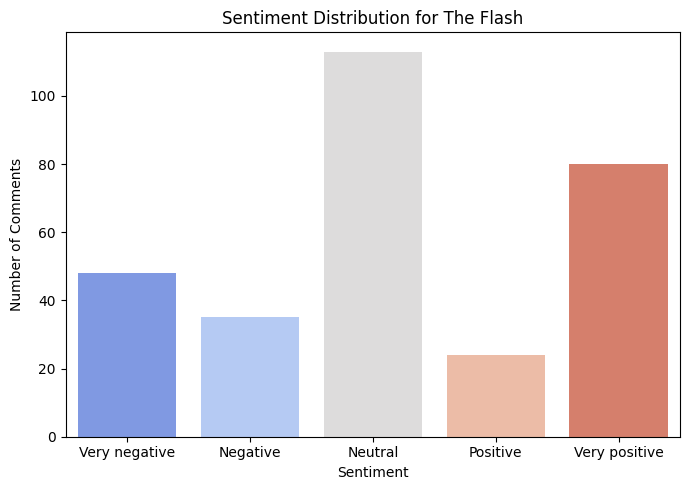

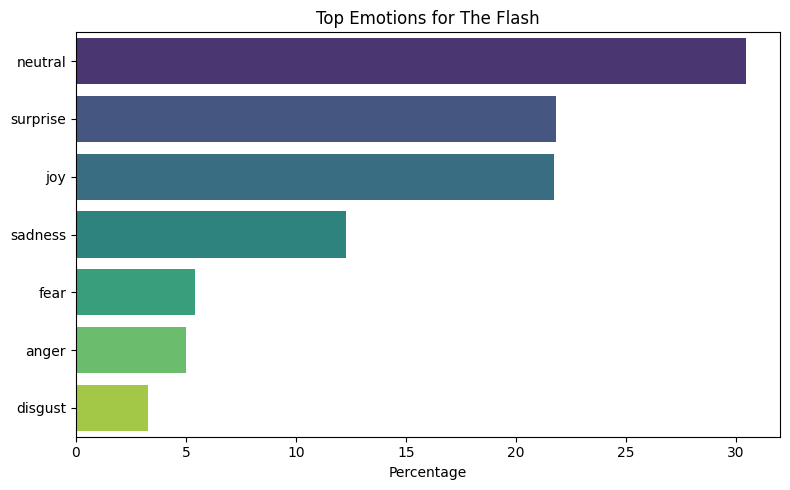


Generating plots for: Barbie


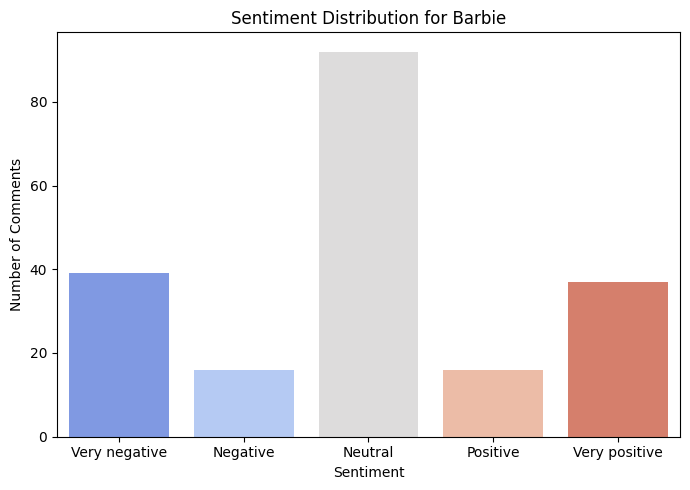

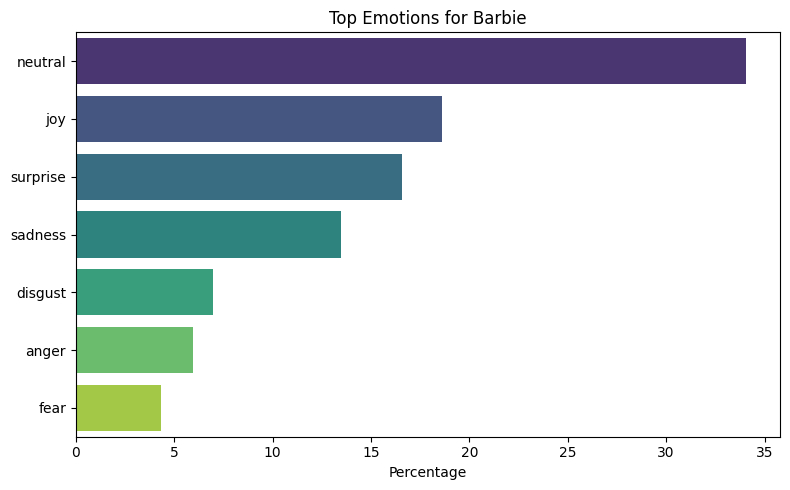


Generating plots for: Oppenheimer


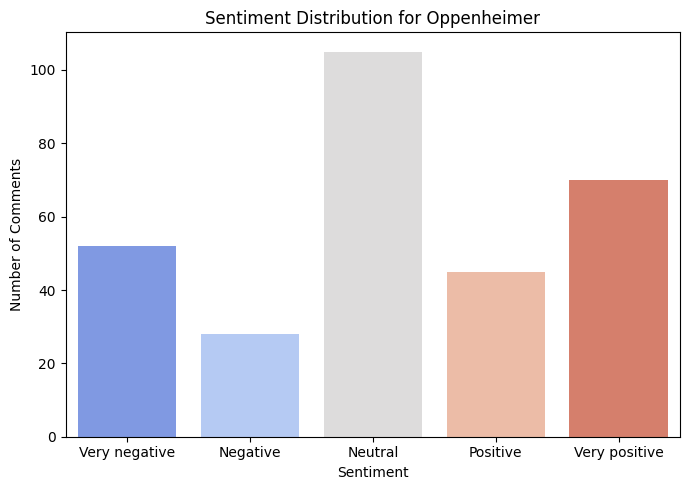

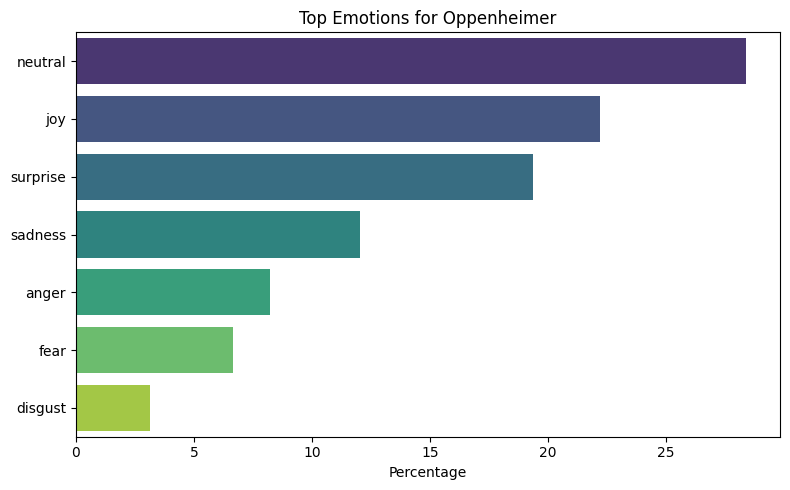


Generating plots for: Snow White


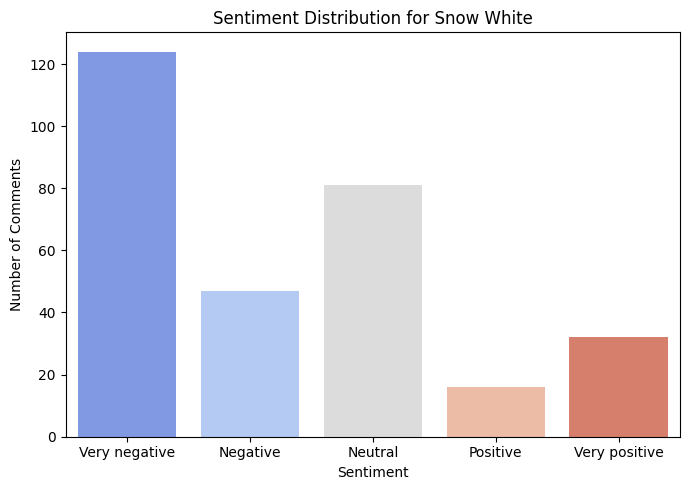

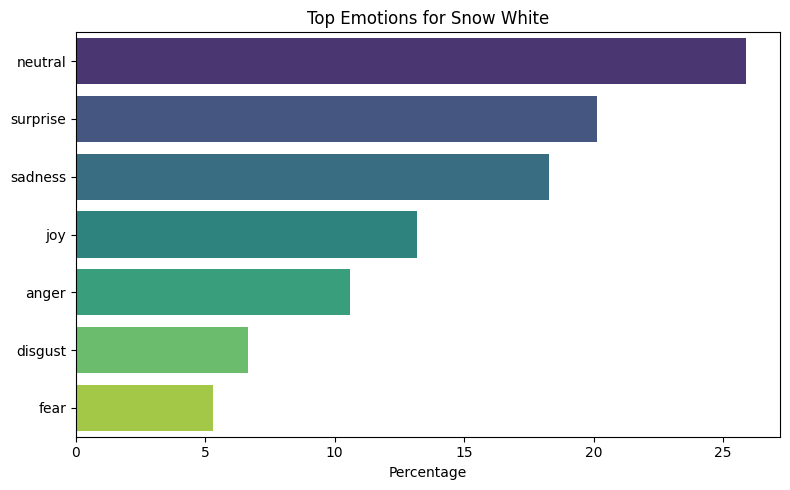

In [43]:
os.makedirs("outputs", exist_ok=True)

for movie in movies:
    cleaned_name = movie.lower().replace(" ", "_")
    filename = f"movie_data/{cleaned_name}_comments.csv"

    try:
        print(f"\nGenerating plots for: {movie}")
        data = pd.read_csv(filename)

        # run analysis and generate plots
        analysis = collector.analyze_sentiment_and_emotion_distribution(data)
        plot_sentiment_distribution(data, movie)
        plot_top_emotions(analysis, movie)

    except Exception as e:
        print(f"Failed for {movie}: {e}")
